In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.3 MB/s eta 0:00:00


## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/3차 프로젝트_Early Bird팀/[참고자료] 문장 유형 분류 AI 경진대회/open'
mypath = '/content/drive/MyDrive/3차 프로젝트_Early Bird팀/은아/'

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import time

from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.feature_extraction.text import TfidfVectorizer # baseline code용 tfidef vectorirzer(또는 tokenizer)
from sklearn import preprocessing
from sklearn.metrics import f1_score

from transformers import AutoModel, AutoTokenizer  # 사용하고자 하는 모델, 토크나이저 적용시 필요
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm # process bar 표시용

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device  # pt 코드에서 필요함

device(type='cuda')

## Hyperparameter Setting

In [ ]:
CFG = {
    'EPOCHS':5,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':32,  # 커질수록 속도 빨라짐(GPU활용 극대화),32 64 정도 추천한다고 함(다른 의견도 있음)
    'SEED':41,
    'SENTENCE_LENGTH' :90,
    'FOLD' : 5
}

## Fixed RandomSeed

https://tempdev.tistory.com/28

https://pytorch.org/docs/stable/notes/randomness.html


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False 
    torch.backends.cudnn.benchmark = True  
    # torch.use_deterministic_algorithms(True)

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [ ]:
df = pd.read_csv(path+'/train.csv')
test = pd.read_csv(path+'/test.csv')

## K-Fold 

In [ ]:
# 제공된 학습데이터를 학습 / 검증 데이터셋으로 재 분할

''' stratified수행시 좋아질 수 있음 
    k-fold로 변형 필요 '''

# train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CFG['SEED'])

folds = StratifiedKFold(n_splits=5, random_state=CFG['SEED'], shuffle=True)

df['kfold'] = -1
for i in range(5):
    df_idx, valid_idx = list(folds.split(df.values, df['label']))[i]    # split data to generate train and validation sets
    valid = df.iloc[valid_idx]

    df.loc[df[df.ID.isin(valid.ID) == True].index.to_list(), 'kfold'] = i

## Data Pre-processing
### 1. 문장(Text) 벡터화
### 2. Label Encoding (유형, 극성, 시제, 확실성)

## KLUE-PLMs(pretrained language models) 
We have trained 2 models: KLUE-BERT and KLUE-RoBERTa. <br>

| Model                | Embedding size | Hidden size | # Layers | # Heads |
|----------------------|----------------|-------------|----------|---------|
| KLUE-BERT-base            | 768            | 768         | 12       | 12      |
|                           |                |             |          |         |
| KLUE-RoBERTa-small        | 768            | 768         | 6        | 12      |
| KLUE-RoBERTa-base         | 768            | 768         | 12       | 12      |
| KLUE-RoBERTa-large        | 1024           | 1024        | 24       | 16      |

`NOTE`:  All the pretrained models are uploaded in Huggingface Model Hub. Check https://huggingface.co/klue.



In [ ]:
# # 1. 문장(Text) 벡터화 -> TfidfVectorizer
# vectorizer = TfidfVectorizer(min_df = 4, analyzer = 'word', ngram_range=(1, 2))  # 최소한 단어가 4번은 나온거 이상만 사용, unigrams + bigrams
# vectorizer.fit(np.array(train["문장"]))

# train_vec = vectorizer.transform(train["문장"])
# val_vec = vectorizer.transform(val["문장"])
# test_vec = vectorizer.transform(test["문장"])

# print(train_vec.shape, val_vec.shape, test_vec.shape)   
# # 9351 차원의 벡터로 특성 표현



'''https://huggingface.co/models
여기서 모델 검색후 적용, AutoModel, AutoTokenizer로 적용가능
BERT계열은 적용가능
monologg/kobigbird-bert-base
klue/roberta-base
klue/roberta-large
klue/roberta-small

GPT 계열은 embedding방식이 달라서 코드 변형 필요한듯
'skt/kogpt2-base-v2'
'''

pretrained_model = 'monologg/kobigbird-bert-base' 

base_model = AutoModel.from_pretrained(pretrained_model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# # 90개 token 으로 truncate하고 padding, pt는 pytorch 타입이라는 의미, tf로쓰면 tensorflow 타입으로 바꿀 수 있음
# # 여기서 90개는 대략 표준분산 3배수로 짜른거 (EDA 참조), 3 sigma rule(68-95-99.7 rule)
# # train_tokenized_texts = [tokenizer.tokenize(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt')  for sent in train["문장"]]
# train_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=CFG['SENTENCE_LENGTH'], truncation=True, return_tensors='pt')  for sent in train["문장"]]
# # NOTE: Use BertTokenizer instead of RobertaTokenizer. (AutoTokenizer will load BertTokenizer) 
# # documentaion에 따르면 bertokenizer 쓰는거라고 함
# # 기본(base/small) 모델 768차원, 라지(large) 모델 1024차원
# # val_tokenized_texts = [tokenizer.tokenize(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt') for sent in val["문장"]]
# val_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=CFG['SENTENCE_LENGTH'], truncation=True, return_tensors='pt')  for sent in val["문장"]]

## Label Encoding

In [ ]:
# 2. Label Encoding (유형, 극성, 시제, 확실성) - 이거는 베이스라인 코드 써도 될듯
type_le = preprocessing.LabelEncoder()
df["유형"] = type_le.fit_transform(df["유형"].values)

polarity_le = preprocessing.LabelEncoder()
df["극성"] = polarity_le.fit_transform(df["극성"].values)

tense_le = preprocessing.LabelEncoder()
df["시제"] = tense_le.fit_transform(df["시제"].values)

certainty_le = preprocessing.LabelEncoder()
df["확실성"] = certainty_le.fit_transform(df["확실성"].values)

In [ ]:
df_labels = {
    'type' : df["유형"].values,
    'polarity' : df["극성"].values,
    'tense' : df["시제"].values,
    'certainty' : df["확실성"].values
}

## CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_text, labels= None):
        self.texts = tokenized_text
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]

        if self.labels is not None:          
            st_type = self.labels['type'][index]
            st_polarity = self.labels['polarity'][index]
            st_tense = self.labels['tense'][index]
            st_certainty = self.labels['certainty'][index]

            return text, st_type, st_polarity, st_tense, st_certainty
        else:
            return text, torch.Tensor([-1,-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1])

## Model Define

In [ ]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # if model_path == 'monologg/kobigbird-bert-base':
        #     config.attention_type = "original_full"
        # self.base_model = AutoModel.from_pretrained(model_path, config=config)
        self.base_model = AutoModel.from_pretrained(pretrained_model).to(device)
        try:
            self.out = self.base_model.encoder.layer[-1].output.dense.out_features
        except:
            self.out = 768
        # self.linear = nn.Linear(768, 768//2)

        self.type_classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.out, out_features=4),    # 유형 : 문장의 유형 (사실형, 추론형, 대화형, 예측형)
            # nn.Softmax(dim=1)
        )
        self.polarity_classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.out, out_features=3), # 극성 : 문장의 극성 (긍정, 부정, 미정)
            # nn.Softmax(dim=1)
        )
        self.tense_classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.out, out_features=3), # 시제 : 문장의 시제 (과거, 현재, 미래)
            # nn.Softmax(dim=1)            
        )
        self.certainty_classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.out, out_features=2), # 확실성 : 문장의 확실성 (확실, 불확실)
            # nn.Softmax(dim=1)            
        )
        
    def forward(self, input_ids, attention_mask, labels=None, token_type_ids=None):
        x = self.base_model(input_ids=input_ids, attention_mask=attention_mask)[0]

        # x = self.linear(x)
        # 문장 유형, 극성, 시제, 확실성을 각각 분류
        type_output = self.type_classifier(x[:,0,:].view(-1,self.out))
        polarity_output = self.polarity_classifier(x[:,0,:].view(-1,self.out))
        tense_output = self.tense_classifier(x[:,0,:].view(-1,self.out))
        certainty_output = self.certainty_classifier(x[:,0,:].view(-1,self.out))
        return type_output, polarity_output, tense_output, certainty_output

## Train

In [ ]:
def TRAIN(model, optimizer, train_loader, val_loader, scheduler, device, fold):
    model.to(device)
    
    criterion = {
        'type' : nn.CrossEntropyLoss().to(device),
        'polarity' : nn.CrossEntropyLoss().to(device),
        'tense' : nn.CrossEntropyLoss().to(device),
        'certainty' : nn.CrossEntropyLoss().to(device)
    }
    
    best_loss = 999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        i = 0
        for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(iter(train_loader)): # 각각의 train data iteration 
            
            # sentence = sentence.to(device)

            # attention_mask = train_input['attention_mask'].to(device)
            # input_ids = train_input['input_ids'].squeeze(1).to(device)
            
            input_ids = sentence.input_ids.squeeze(1).to(device)
            attention_mask = sentence.attention_mask.to(device)
            
            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)
            
            optimizer.zero_grad()  # 초기화

            type_logit, polarity_logit, tense_logit, certainty_logit = model(input_ids,attention_mask)  # 모델 적용

            loss = 0.25 * criterion['type'](type_logit, type_label) + \
                    0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                    0.25 * criterion['tense'](tense_logit, tense_label) + \
                    0.25 * criterion['certainty'](certainty_logit, certainty_label)


            loss.backward()  # 역전파

            optimizer.step()  # 한단계 진행

            train_loss.append(loss.item()) # loss 합산

        val_loss, val_type_f1, val_polarity_f1, val_tense_f1, val_certainty_f1, f1_mult = validation(model, val_loader, criterion, device)

        val_criterion =  [val_loss, val_type_f1, val_polarity_f1, val_tense_f1, val_certainty_f1, f1_mult]

        print(f'Fold: [{fold+1}] Epoch : [{epoch}] F1 : [{f1_mult:.5f}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] 유형 F1 : [{val_type_f1:.5f}] 극성 F1 : [{val_polarity_f1:.5f}] 시제 F1 : [{val_tense_f1:.5f}] 확실성 F1 : [{val_certainty_f1:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_loss)
            
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            
    return best_model, val_criterion

In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    type_labels, polarity_labels, tense_labels, certainty_labels = [], [], [], []
    
    
    with torch.no_grad():
        for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(iter(val_loader)):

            # sentence = sentence.to(device)
            input_ids = sentence.input_ids.squeeze(1).to(device)
            attention_mask = sentence.attention_mask.to(device)
            
            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)
            
            type_logit, polarity_logit, tense_logit, certainty_logit = model(input_ids,attention_mask)
            
            loss = 0.25 * criterion['type'](type_logit, type_label) + \
                    0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                    0.25 * criterion['tense'](tense_logit, tense_label) + \
                    0.25 * criterion['certainty'](certainty_logit, certainty_label)
            
            val_loss.append(loss.item())
          
            type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
            type_labels += type_label.detach().cpu().numpy().tolist()
            
            polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
            polarity_labels += polarity_label.detach().cpu().numpy().tolist()
            
            tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
            tense_labels += tense_label.detach().cpu().numpy().tolist()
            
            certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
            certainty_labels += certainty_label.detach().cpu().numpy().tolist()
    
    type_f1 = f1_score(type_labels, type_preds, average='weighted')
    polarity_f1 = f1_score(polarity_labels, polarity_preds, average='weighted')
    tense_f1 = f1_score(tense_labels, tense_preds, average='weighted')
    certainty_f1 = f1_score(certainty_labels, certainty_preds, average='weighted')

    f1_mult = type_f1 * polarity_f1 * tense_f1 * certainty_f1
    
    return np.mean(val_loss), type_f1, polarity_f1, tense_f1, certainty_f1, f1_mult

In [ ]:
# 결과 저장 위치 만들기
model_name = pretrained_model.replace('/','-')
foldpath = mypath+'/'+model_name+f"_BatchSize_{CFG['BATCH_SIZE']}_Epoch_{CFG['EPOCHS']}_{time.strftime('%c', time.localtime(time.time()))}"+'/'
os.mkdir(foldpath)  # 폴더 생성

## Run

In [ ]:
val_criterion = []

for fold in range (CFG['FOLD']):
    # reset train and validation sets based on fold
    train = df[df["kfold"] != fold].reset_index(drop=True)
    val = df[df["kfold"] == fold].reset_index(drop=True)

    train_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=CFG['SENTENCE_LENGTH'], truncation=True, return_tensors='pt')  for sent in train["문장"]]
    val_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=CFG['SENTENCE_LENGTH'], truncation=True, return_tensors='pt')  for sent in val["문장"]]    

    train_labels = {
        'type' : train["유형"].values,
        'polarity' : train["극성"].values,
        'tense' : train["시제"].values,
        'certainty' : train["확실성"].values
    }

    val_labels = {
        'type' : val["유형"].values,
        'polarity' : val["극성"].values,
        'tense' : val["시제"].values,
        'certainty' : val["확실성"].values
    }    

    model = CustomModel()
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

    train_dataset = CustomDataset(train_tokenized_texts, train_labels)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val_tokenized_texts, val_labels)
    val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    infer_model, val_c = TRAIN(model, optimizer, train_loader, val_loader, scheduler, device, fold)

    val_criterion.append(val_c)

    torch.save(infer_model, foldpath+f'Model_FOLD[{fold}].pt')

# val_criterion = np.mean(val_criterion, axis = 0)

# print(f'F1 : [{val_criterion[5]:.5f}] Val Loss : [{val_criterion[0]:.5f}] 유형 F1 : [{val_criterion[1]:.5f}] 극성 F1 : [{val_criterion[2]:.5f}] 시제 F1 : [{val_criterion[3]:.5f}] 확실성 F1 : [{val_criterion[4]:.5f}]')
      



Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/414 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 92 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [1] Epoch : [1] F1 : [0.70402] Train Loss : [0.28809] Val Loss : [0.22235] 유형 F1 : [0.88158] 극성 F1 : [0.96680] 시제 F1 : [0.89344] 확실성 F1 : [0.92453]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [1] Epoch : [2] F1 : [0.69242] Train Loss : [0.21045] Val Loss : [0.23162] 유형 F1 : [0.86553] 극성 F1 : [0.97303] 시제 F1 : [0.89029] 확실성 F1 : [0.92349]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [1] Epoch : [3] F1 : [0.71878] Train Loss : [0.17717] Val Loss : [0.21048] 유형 F1 : [0.88585] 극성 F1 : [0.97176] 시제 F1 : [0.90506] 확실성 F1 : [0.92258]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [1] Epoch : [4] F1 : [0.71969] Train Loss : [0.14637] Val Loss : [0.22644] 유형 F1 : [0.88688] 극성 F1 : [0.97188] 시제 F1 : [0.90039] 확실성 F1 : [0.92733]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [1] Epoch : [5] F1 : [0.70165] Train Loss : [0.12346] Val Loss : [0.25988] 유형 F1 : [0.87450] 극성 F1 : [0.97382] 시제 F1 : [0.88910] 확실성 F1 : [0.92669]


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/414 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 92 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [2] Epoch : [1] F1 : [0.70135] Train Loss : [0.27668] Val Loss : [0.22007] 유형 F1 : [0.87133] 극성 F1 : [0.97031] 시제 F1 : [0.89635] 확실성 F1 : [0.92547]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [2] Epoch : [2] F1 : [0.68759] Train Loss : [0.20275] Val Loss : [0.22126] 유형 F1 : [0.88142] 극성 F1 : [0.96818] 시제 F1 : [0.88570] 확실성 F1 : [0.90971]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [2] Epoch : [3] F1 : [0.68374] Train Loss : [0.16702] Val Loss : [0.25206] 유형 F1 : [0.86449] 극성 F1 : [0.96520] 시제 F1 : [0.88901] 확실성 F1 : [0.92175]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [2] Epoch : [4] F1 : [0.69916] Train Loss : [0.13771] Val Loss : [0.24486] 유형 F1 : [0.87420] 극성 F1 : [0.97229] 시제 F1 : [0.89409] 확실성 F1 : [0.92000]
Epoch 00004: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [2] Epoch : [5] F1 : [0.71045] Train Loss : [0.08562] Val Loss : [0.26422] 유형 F1 : [0.88551] 극성 F1 : [0.97457] 시제 F1 : [0.89223] 확실성 F1 : [0.92268]


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/414 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 92 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [3] Epoch : [1] F1 : [0.67121] Train Loss : [0.33521] Val Loss : [0.24194] 유형 F1 : [0.86433] 극성 F1 : [0.94664] 시제 F1 : [0.89322] 확실성 F1 : [0.91840]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [3] Epoch : [2] F1 : [0.46770] Train Loss : [0.30788] Val Loss : [0.40638] 유형 F1 : [0.77158] 극성 F1 : [0.93325] 시제 F1 : [0.73866] 확실성 F1 : [0.87931]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [3] Epoch : [3] F1 : [0.69337] Train Loss : [0.24130] Val Loss : [0.22917] 유형 F1 : [0.87606] 극성 F1 : [0.96682] 시제 F1 : [0.89303] 확실성 F1 : [0.91670]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [3] Epoch : [4] F1 : [0.69123] Train Loss : [0.19193] Val Loss : [0.24281] 유형 F1 : [0.88016] 극성 F1 : [0.96763] 시제 F1 : [0.87059] 확실성 F1 : [0.93226]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [3] Epoch : [5] F1 : [0.70535] Train Loss : [0.16277] Val Loss : [0.25088] 유형 F1 : [0.87623] 극성 F1 : [0.96889] 시제 F1 : [0.89862] 확실성 F1 : [0.92456]


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/414 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 92 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [4] Epoch : [1] F1 : [0.68766] Train Loss : [0.32225] Val Loss : [0.23493] 유형 F1 : [0.87211] 극성 F1 : [0.96812] 시제 F1 : [0.88084] 확실성 F1 : [0.92463]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [4] Epoch : [2] F1 : [0.19216] Train Loss : [0.46868] Val Loss : [0.51578] 유형 F1 : [0.73740] 극성 F1 : [0.93340] 시제 F1 : [0.31767] 확실성 F1 : [0.87887]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [4] Epoch : [3] F1 : [0.14729] Train Loss : [0.51603] Val Loss : [0.51462] 유형 F1 : [0.73740] 극성 F1 : [0.93340] 시제 F1 : [0.24348] 확실성 F1 : [0.87887]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [4] Epoch : [4] F1 : [0.14729] Train Loss : [0.51565] Val Loss : [0.51737] 유형 F1 : [0.73740] 극성 F1 : [0.93340] 시제 F1 : [0.24348] 확실성 F1 : [0.87887]
Epoch 00004: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [4] Epoch : [5] F1 : [0.14729] Train Loss : [0.51361] Val Loss : [0.51667] 유형 F1 : [0.73740] 극성 F1 : [0.93340] 시제 F1 : [0.24348] 확실성 F1 : [0.87887]


Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/414 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 92 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [5] Epoch : [1] F1 : [0.69750] Train Loss : [0.27908] Val Loss : [0.21841] 유형 F1 : [0.87841] 극성 F1 : [0.96740] 시제 F1 : [0.89031] 확실성 F1 : [0.92195]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [5] Epoch : [2] F1 : [0.71415] Train Loss : [0.20326] Val Loss : [0.21504] 유형 F1 : [0.88709] 극성 F1 : [0.97205] 시제 F1 : [0.89721] 확실성 F1 : [0.92307]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [5] Epoch : [3] F1 : [0.69838] Train Loss : [0.17179] Val Loss : [0.24310] 유형 F1 : [0.88685] 극성 F1 : [0.97436] 시제 F1 : [0.87013] 확실성 F1 : [0.92884]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [5] Epoch : [4] F1 : [0.70126] Train Loss : [0.14615] Val Loss : [0.23635] 유형 F1 : [0.88001] 극성 F1 : [0.96971] 시제 F1 : [0.89322] 확실성 F1 : [0.92000]


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Fold: [5] Epoch : [5] F1 : [0.70283] Train Loss : [0.11770] Val Loss : [0.26597] 유형 F1 : [0.88041] 극성 F1 : [0.96808] 시제 F1 : [0.88903] 확실성 F1 : [0.92756]
Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.
F1 : [0.59351] Val Loss : [0.31153] 유형 F1 : [0.85081] 극성 F1 : [0.96375] 시제 F1 : [0.76249] 확실성 F1 : [0.91607]


## Inference

In [ ]:
test_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=128, truncation=True, return_tensors='pt')  for sent in test["문장"]]
test_dataset = CustomDataset(test_tokenized_texts,df_labels)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=0)

In [ ]:
# filepath =input()
file_list = os.listdir(foldpath)
# model = torch.load(filepath)

file_list_pt = [file for file in file_list if file.endswith(".pt")]

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    
    with torch.no_grad():
        for sentence, _, _, _, _ in tqdm(test_loader):
            # sentence = sentence.to(device)
            input_ids = sentence.input_ids.squeeze(1).to(device)
            attention_mask = sentence.attention_mask.to(device)
                        
            type_logit, polarity_logit, tense_logit, certainty_logit = model(input_ids, attention_mask)
            
            type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
            polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
            tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
            certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
    return type_preds, polarity_preds, tense_preds, certainty_preds

In [ ]:
for model_n in file_list_pt:
  model = torch.load(foldpath+model_n)
  type_preds, polarity_preds, tense_preds, certainty_preds = inference(model, test_loader, device)

  # type_preds = type_le.inverse_transform(type_preds)
  # polarity_preds = polarity_le.inverse_transform(polarity_preds)
  # tense_preds = tense_le.inverse_transform(tense_preds)
  # certainty_preds = certainty_le.inverse_transform(certainty_preds)

  # predictions = []
  # for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
  #     predictions.append(type_pred+'-'+polarity_pred+'-'+tense_pred+'-'+certainty_pred)  

  fold_submit = pd.read_csv(path+'/sample_submission.csv')
  fold_submit = fold_submit.drop(columns = ['label'])
  fold_submit['type'] = type_preds
  fold_submit['polarity'] = polarity_preds
  fold_submit['tense'] = tense_preds
  fold_submit['certainty'] = certainty_preds

  fold_submit.to_csv(foldpath+model_n+".csv", index=False)

  0%|          | 0/7090 [00:00<?, ?it/s]

  0%|          | 0/7090 [00:00<?, ?it/s]

  0%|          | 0/7090 [00:00<?, ?it/s]

  0%|          | 0/7090 [00:00<?, ?it/s]

  0%|          | 0/7090 [00:00<?, ?it/s]

## Submission

In [ ]:
from collections import Counter
file_list = os.listdir(foldpath)
file_list_csv = [file for file in file_list if file.endswith(".csv")]

In [ ]:
submit = pd.DataFrame(columns = fold_submit.columns)
submit.ID = fold_submit.ID
submit.type = submit.type.apply(lambda x:[])
submit.polarity = submit.polarity.apply(lambda x:[])
submit.tense = submit.tense.apply(lambda x:[])
submit.certainty = submit.certainty.apply(lambda x:[])

for fold_result in file_list_csv:

    fold_test= pd.read_csv(foldpath+fold_result)

    for i in range(len(submit)):
      submit.type[i].append(fold_test['type'][i])
      submit.polarity[i].append(fold_test['polarity'][i])
      submit.tense[i].append(fold_test['tense'][i])
      submit.certainty[i].append(fold_test['certainty'][i])

for i in range(len(submit)): 
  submit.type[i] = [Counter(submit.type[i]).most_common()[0][0]]
  submit.polarity[i] =[Counter(submit.polarity[i]).most_common()[0][0]]
  submit.tense[i] = [Counter(submit.tense[i]).most_common()[0][0]] 
  submit.certainty[i] = [Counter(submit.certainty[i]).most_common()[0][0]]    

type_preds = submit.type.apply(type_le.inverse_transform)
polarity_preds = submit.polarity.apply(polarity_le.inverse_transform)
tense_preds = submit.tense.apply(tense_le.inverse_transform)
certainty_preds = submit.certainty.apply(certainty_le.inverse_transform)

predictions = []
for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
    predictions.append(type_pred[0]+'-'+polarity_pred[0]+'-'+tense_pred[0]+'-'+certainty_pred[0]) 
submit['label'] = predictions
submit= submit.drop(columns=['type','polarity','tense','certainty'])      

In [ ]:
submit.to_csv(foldpath+'제출용_'+model_name+f"_BatchSize_{CFG['BATCH_SIZE']}_Epoch_{CFG['EPOCHS']}.csv", index=False)

# 개별 문장에 적용해보기

In [ ]:
def inference_text(text) :

  type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []

  ts = tokenizer(test_text,padding='max_length', max_length=90, truncation=True, return_tensors='pt')

  for model_n in file_list_pt:
    model = torch.load(foldpath+model_n)
    model.eval()
    
    type_logit, polarity_logit, tense_logit, certainty_logit =model(ts.input_ids.to(device), ts.attention_mask.to(device)) 

    type_preds+=(type_logit.argmax(1).detach().cpu().numpy().tolist())
    polarity_preds+=(polarity_logit.argmax(1).detach().cpu().numpy().tolist())
    tense_preds+=(tense_logit.argmax(1).detach().cpu().numpy().tolist())
    certainty_preds+=(certainty_logit.argmax(1).detach().cpu().numpy().tolist())

  type_preds = Counter(type_preds).most_common()[0][0]
  polarity_preds = Counter(polarity_preds).most_common()[0][0]
  tense_preds = Counter(tense_preds).most_common()[0][0]
  certainty_preds = Counter(certainty_preds).most_common()[0][0]

  type_preds = type_le.inverse_transform([type_preds])
  polarity_preds = polarity_le.inverse_transform([polarity_preds])
  tense_preds = tense_le.inverse_transform([tense_preds])
  certainty_preds = certainty_le.inverse_transform([certainty_preds])

  predictions = []
  for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
    predictions.append(type_pred+'-'+polarity_pred+'-'+tense_pred+'-'+certainty_pred)

  return (predictions)

In [ ]:
test_text = "이스라엘군이 26일(현지시각) 요르단강 서안에서 팔레스타인 무장세력 소탕작전에 나서 적어도 9명이 숨졌다. "
# test_text = "26일 JTBC에 따르면 지난 20일 오후 4시 반쯤 강원도 고성의 한 대나무숲에서 태어난 지 3일에서 일주일 정도로 추정되는 신생아가 구조됐다. "
inference_text(test_text)

['사실형-긍정-과거-확실']

# 오답 출력해보기

In [ ]:
review_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt')  for sent in df["문장"]]
review_dataset = CustomDataset(review_tokenized_texts, df_labels)
review_loader = DataLoader(review_dataset, shuffle=False, num_workers=0)

In [ ]:
review = pd.DataFrame(columns = ['ID','type','polarity','tense','certainty'])
review.ID = df.ID
review.type = review.type.apply(lambda x:[])
review.polarity = review.polarity.apply(lambda x:[])
review.tense = review.tense.apply(lambda x:[])
review.certainty = review.certainty.apply(lambda x:[])

for model_n in file_list_pt:

  model = torch.load(foldpath+model_n)
  type_preds, polarity_preds, tense_preds, certainty_preds = inference(model, review_loader, device)

  for i in range(len(review)):
    review.type[i].append(type_preds[i])
    review.polarity[i].append(polarity_preds[i])
    review.tense[i].append(tense_preds[i])
    review.certainty[i].append(certainty_preds [i])

for i in range(len(review)): 
  review.type[i] = [Counter(review.type[i]).most_common()[0][0]]
  review.polarity[i] =[Counter(review.polarity[i]).most_common()[0][0]]
  review.tense[i] = [Counter(review.tense[i]).most_common()[0][0]] 
  review.certainty[i] = [Counter(review.certainty[i]).most_common()[0][0]]    

type_preds = review.type.apply(type_le.inverse_transform)
polarity_preds = review.polarity.apply(polarity_le.inverse_transform)
tense_preds = review.tense.apply(tense_le.inverse_transform)
certainty_preds = review.certainty.apply(certainty_le.inverse_transform)

predictions = []
for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
    predictions.append(type_pred[0]+'-'+polarity_pred[0]+'-'+tense_pred[0]+'-'+certainty_pred[0]) 
review['label'] = predictions

  0%|          | 0/16541 [00:00<?, ?it/s]

  0%|          | 0/16541 [00:00<?, ?it/s]

  0%|          | 0/16541 [00:00<?, ?it/s]

  0%|          | 0/16541 [00:00<?, ?it/s]

  0%|          | 0/16541 [00:00<?, ?it/s]

In [ ]:
review_note = pd.DataFrame(columns=('문장', '예측유형','예측극성','예측시제','예측확실성', '정답유형','정답극성','정답시제','정답확실성'))

type_label = type_le.inverse_transform(df.유형)
polarity_label = polarity_le.inverse_transform(df.극성)
tense_label = tense_le.inverse_transform(df.시제)
certainty_label = certainty_le.inverse_transform(df.확실성)

type_preds = type_le.inverse_transform(review.type.apply(lambda x: x[0]))
polarity_preds = polarity_le.inverse_transform(review.polarity.apply(lambda x: x[0]))
tense_preds = tense_le.inverse_transform(review.tense.apply(lambda x: x[0]))
certainty_preds = certainty_le.inverse_transform(review.certainty.apply(lambda x: x[0]))

type_f1 = f1_score(type_label, type_preds, average=None)
polarity_f1 = f1_score(polarity_label, polarity_preds, average=None)
tense_f1 = f1_score(tense_label, tense_preds, average=None)
certainty_f1 = f1_score(certainty_label, certainty_preds, average=None)

# label인코더 순서대로 리스팅
type_list = ['대화형','사실형', '예측형','추론형']
polarity_list = ['긍정', '미정', '부정']
tense_list = ['과거', '미래', '현재']
certainty_list = ['불확실', '확실']

for pair in zip(type_list,type_f1) :
  print (pair)
for pair in zip(polarity_list,polarity_f1) :
  print (pair)
for pair in zip(tense_list,tense_f1) :
  print (pair)
for pair in zip(certainty_list,certainty_f1) :
  print (pair)

type_f1_w = f1_score(type_label, type_preds, average='weighted')
polarity_f1_w = f1_score(polarity_label, polarity_preds, average='weighted')
tense_f1_w = f1_score(tense_label, tense_preds, average='weighted')
certainty_f1_w = f1_score(certainty_label, certainty_preds, average='weighted')

f1_mult = type_f1_w*polarity_f1_w*tense_f1_w*certainty_f1_w

print(f'F1 : [{f1_mult:.5f}] 유형 F1 : [{type_f1_w:.5f}] 극성 F1 : [{polarity_f1_w:.5f}] 시제 F1 : [{tense_f1_w:.5f}] 확실성 F1 : [{certainty_f1_w:.5f}]')
  
for i in range(len(df)):
  if (type_preds[i] != type_label[i]) or (polarity_preds[i] != polarity_label[i]) or (tense_preds[i] != tense_label[i]) or (certainty_preds[i] != certainty_label[i]) :
    review_note = review_note.append({'문장': df.문장[i],'예측유형':type_preds[i],'예측극성':polarity_preds[i],'예측시제':tense_preds[i],'예측확실성':certainty_preds[i], 
                                      '정답유형':type_label[i],'정답극성':polarity_label[i],'정답시제':tense_label[i],'정답확실성':certainty_label[i]},ignore_index=True)

('대화형', 0.9878472222222222)
('사실형', 0.9844295692665892)
('예측형', 0.743119266055046)
('추론형', 0.9121318022965552)
('긍정', 0.9935666982024598)
('미정', 0.4488188976377953)
('부정', 0.9391771019677996)
('과거', 0.9864383476032748)
('미래', 0.9119897959183674)
('현재', 0.9686626030835426)
('불확실', 0.745016611295681)
('확실', 0.9799830475321119)
F1 : [0.89391] 유형 F1 : [0.97140] 극성 F1 : [0.98568] 시제 F1 : [0.97166] 확실성 F1 : [0.96082]


In [ ]:
review_note

,문장,예측유형,예측극성,예측시제,예측확실성,정답유형,정답극성,정답시제,정답확실성
0,"1회 신청 시 1년까지, 보험료 납입기간 중 최대 3회까지 이용할 수 있다.",사실형,긍정,미래,확실,사실형,긍정,현재,확실
1,팔각정은 관광도로로 유명한 ＇북악 스카이웨이＇로 인근에 있어 이륜차 운전자들이 즐겨...,사실형,긍정,현재,확실,추론형,긍정,현재,불확실
2,사람 친구는 어느 한쪽에 애인이 생기면 끊어주는 게 쌈빡한 예의 아닐까.,대화형,긍정,현재,확실,대화형,긍정,미래,확실
3,"＇월드 오브 드래곤네스트＇는 오는 8일 말레이시아, 싱가포르, 인도네시아, 필리핀,...",사실형,긍정,현재,확실,사실형,미정,현재,확실
4,＂OTT 사업을 처음부터 직접 키우려 했다면 쿠팡플레이의 ＇타임 투 마켓(Time ...,추론형,긍정,과거,불확실,예측형,부정,과거,확실
...,...,...,...,...,...,...,...,...,...
1545,이에 삼양식품이 수출 비중이 높은 만큼 달러 강세의 수혜를 입을 것이라는 전망이다.,예측형,긍정,미래,불확실,예측형,긍정,미래,확실
1546,대학원 정원 규제 완화가 기업 활동에 직접적인 규제가 아님에도 규제 개선 방안에 포...,사실형,긍정,현재,확실,사실형,긍정,현재,불확실
1547,법원 밖에서는 양심적 병역거부자를 위한 대체복무 방안 역시 법제화되는 등 이들을 위...,사실형,긍정,현재,확실,추론형,긍정,현재,확실
1548,"5월에는 인천-프랑크푸르트 노선을 5월28일부터 주 4회에서 주 5회로 증편하고, ...",사실형,긍정,미래,확실,사실형,미정,미래,확실


- 데이터가 적은 label의 F1 Score가 전반적으로 낮게 나옴

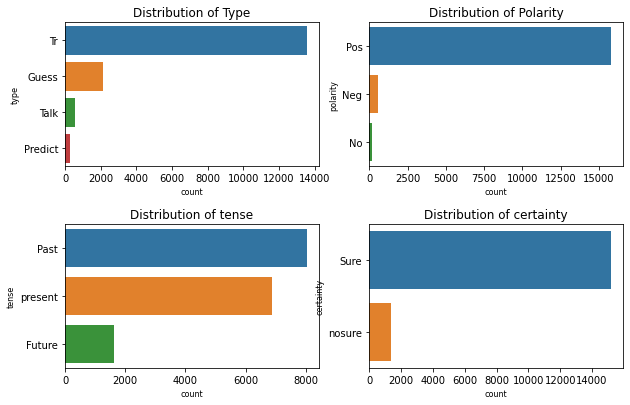

In [ ]:
review_note.to_csv(foldpath+'오답노트_'+model_name+f"_BatchSize_{CFG['BATCH_SIZE']}_Epoch_{CFG['EPOCHS']}.csv", index=False, encoding = 'euc-kr')